In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# plt.style.use('science')

___
### ENSEMBLE DAT

In [3]:
# Config

DATA_DIR = '/Users/Pereiro/.julia/dev/RegulationImageMC_2024/data/0.2.0-ecoli.core/sklearn'

In [4]:
# Load Raw Data
dfpath = os.path.join(DATA_DIR, 'fba.features.df.41646.csv')
X0 = pd.read_csv(dfpath)
X0.describe()

,downset.hash,down_factor,downfactor.PPCK,downfactor.PYK,downfactor.SUCCt3,downfactor.FBP,downfactor.FORt2,downfactor.FORt,downfactor.FRD7,downfactor.GLCpts,...,fba.MDH,fba.ME1,fba.ME2,fba.NADH16,fba.NADTRHD,fba.NH4t,fba.O2t,fba.PDH,fba.biom,fba.EX_glc__D_e
count,4.164600e+04,41646.0,41646.000000,41646.000000,41646.000000,41646.000000,41646.000000,41646.000000,41646.000000,41646.000000,...,41646.000000,41646.000000,41646.000000,41646.000000,41646.000000,41646.000000,41646.000000,41646.000000,41646.000000,41646.000000
mean,9.227482e+18,0.0,0.781996,0.792897,0.790304,0.773976,0.789584,0.793666,0.797195,0.794074,...,0.117268,0.557678,0.688143,10.205364,2.818972,1.332687,5.568595,3.391576,0.167502,-5.367837
std,5.313062e+18,0.0,0.412895,0.405235,0.407097,0.418260,0.407609,0.404678,0.402093,0.404382,...,8.279788,20.857038,3.934718,44.724518,21.234752,13.523565,33.194013,7.406651,1.105112,4.528559
min,1.962950e+14,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-619.482694,-2046.487118,-24.060134,-4096.201967,-14.553410,-80.974247,-3165.269436,-28.211319,-105.137845,-10.000000
25%,4.628715e+18,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.000000
50%,9.195486e+18,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,2.796667,0.000000,0.000000,1.398333,0.000000,0.000000,-4.195000
75%,1.383940e+19,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.958857,0.000000,0.000000,9.548130,1.305205,1.915358,4.774065,6.712000,0.211663,-0.541290
max,1.844609e+19,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,76.431837,98.305000,98.305000,120.000000,378.220000,1342.841579,60.000000,465.907845,0.873922,32.777715


In [5]:
# Add glc normalized features
X1 = X0.copy()
X1 = X1[X1['fba.biom'] > 0]
X1 = X1[X1['fba.ex_glc'] >= -11]
tonorm_cls = [
    col for col in X1.columns 
    if col.startswith('fba.') and not col == 'fba.ex_glc'
]
for col in tonorm_cls:
    X1[f'norm.{col}'] = X0[col] / X0['fba.ex_glc'].abs()
X1 = X1.replace([np.inf, -np.inf], np.nan).dropna()

# X1['fba.biom'].hist()
# X1['fba.ex_glc'].hist()

KeyError: 'fba.ex_glc'

In [5]:
# remove uninformative columns
todrop = [
    col for col in X1.columns 
        if col.startswith('fba.') and 
        not col == "fba.biom" and
        not col == "fba.ex_glc"
]
todrop.append('downset.hash')
X2 = X1.drop(todrop, axis = 1)
X2["fba.ex_glc"].describe()

count    5729.000000
mean       -9.991820
std         0.207358
min       -10.000000
25%       -10.000000
50%       -10.000000
75%       -10.000000
max        -3.947418
Name: fba.ex_glc, dtype: float64

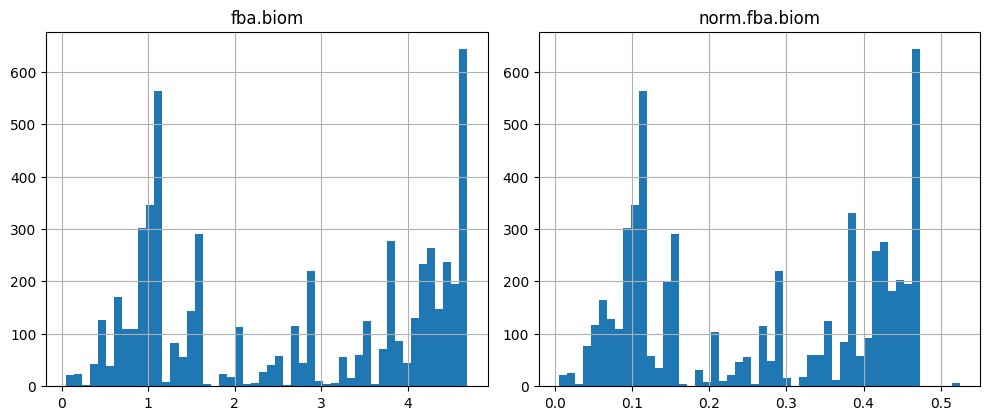

In [6]:
from pandas.plotting import scatter_matrix

# Seleziona le colonne di interesse
toshow_index = ['fba.biom', 'norm.fba.biom']
sel_df = X2[toshow_index]

# Crea un istogramma per ciascuna colonna nel sottogruppo
sel_df.hist(bins=50, figsize=(10, 8), layout=(2, 2)
    # , range = (-0.01, 0.1)
)

# Mostra il grafico
plt.tight_layout()
plt.show()

In [21]:
# 1. Standarization
scaler = StandardScaler()
X3 = scaler.fit_transform(X2)
X3 = pd.DataFrame(X3, index=X2.index, columns=X2.columns)
X3['fba.biom'] = X2['fba.biom'] # skip fba.biom
X3['norm.fba.biom'] = X2['norm.fba.biom'] # skip norm.fba.biom

___
### PCA

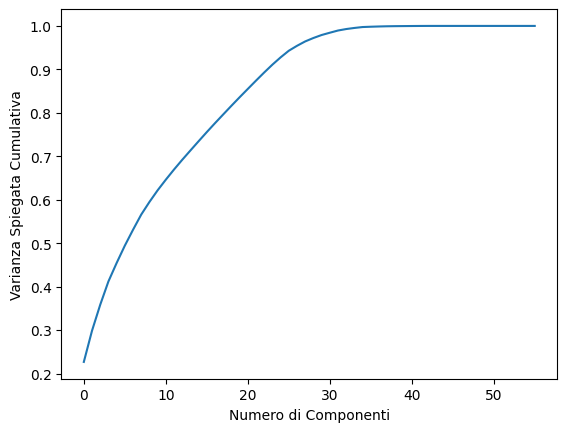

In [8]:
# Esegui PCA
pca = PCA()
pcs = pca.fit_transform(X3)

# Grafico della varianza spiegata
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Numero di Componenti')
plt.ylabel('Varianza Spiegata Cumulativa')
plt.show()

___
### TSNE

In [9]:
# TSNE with all
from sklearn.manifold import TSNE
import seaborn as sns

# Esegui t-SNE
tsne = TSNE(n_components=2, n_jobs=-1)
X3_tsne = tsne.fit_transform(X3)

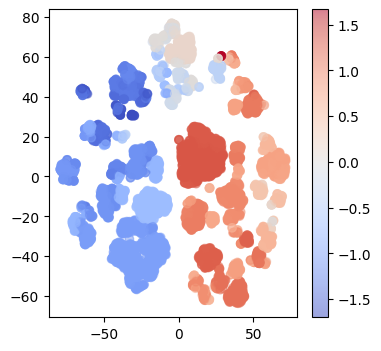

In [18]:
# Visualizza i risultati
plt.figure(figsize=(4,4))
sc = plt.scatter(X3_tsne[:, 0], X3_tsne[:, 1], c=X3['norm.fba.biom'], alpha = 0.5, cmap='coolwarm')
plt.colorbar(sc)
plt.show()

In [11]:
# Data without biomass
X4 = X3.drop(['fba.biom', 'norm.fba.biom'], axis=1)

In [12]:
# Esegui t-SNE
tsne = TSNE(n_components=2, n_jobs=-1)
X4_tsne = tsne.fit_transform(X4)

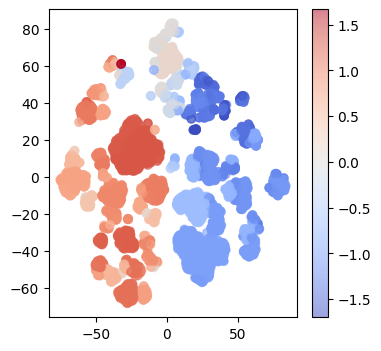

In [17]:
# Visualizza i risultati
plt.figure(figsize=(4,4))
sc = plt.scatter(X4_tsne[:, 0], X4_tsne[:, 1], c=X3['norm.fba.biom'], alpha = 0.5, cmap='coolwarm')
plt.colorbar(sc)
plt.show()

In [14]:
# TSNE without biomass only fluxes
X5 = X3.drop(['fba.biom', 'norm.fba.biom'], axis=1)
todrop_cls = [
    col for col in X5.columns 
    if col.startswith('downfactor.')
]
X5 = X5.drop(todrop_cls, axis=1)

In [15]:
# Esegui t-SNE
tsne = TSNE(n_components=2, n_jobs=-1)
X5_tsne = tsne.fit_transform(X5)

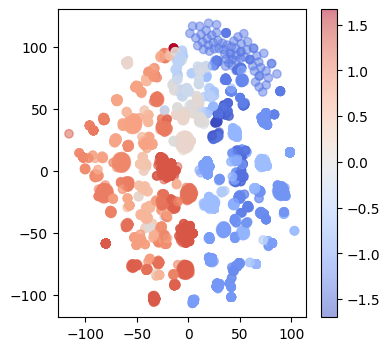

In [16]:
# Visualizza i risultati
plt.figure(figsize=(4,4))
sc = plt.scatter(X5_tsne[:, 0], X5_tsne[:, 1], c=X3['norm.fba.biom'], alpha = 0.5, cmap='coolwarm')
plt.colorbar(sc)
plt.show()

In [23]:
# TSNE without biomass only downregulations
X6 = X3.drop(['fba.biom', 'norm.fba.biom'], axis=1)
todrop_cls = [
    col for col in X6.columns 
    if col.startswith('norm.fba.')
]
X6 = X6.drop(todrop_cls, axis=1)

In [139]:
# Esegui t-SNE
tsne = TSNE(n_components=2, n_jobs=-1)
X6_tsne = tsne.fit_transform(X6)

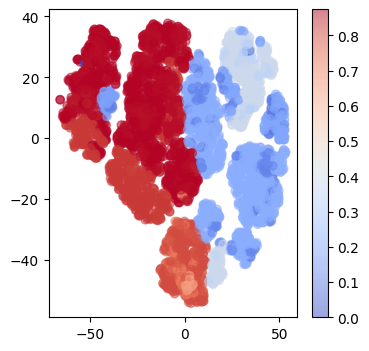

In [140]:
# Visualizza i risultati
# fig, axs = plt.subplots(1)
plt.figure(figsize=(4,4))
sc = plt.scatter(X6_tsne[:, 0], X6_tsne[:, 1], c=X3['fba.biom'], alpha = 0.5, cmap='coolwarm')
plt.colorbar(sc)
plt.show()

In [24]:
# 0.95 PCA reduction
pca95 = PCA(n_components=0.95)
X7 = pca95.fit_transform(X3)

___
### K-Mean

TODO: Check geron K-mean chapter 9 and implement examples using our data

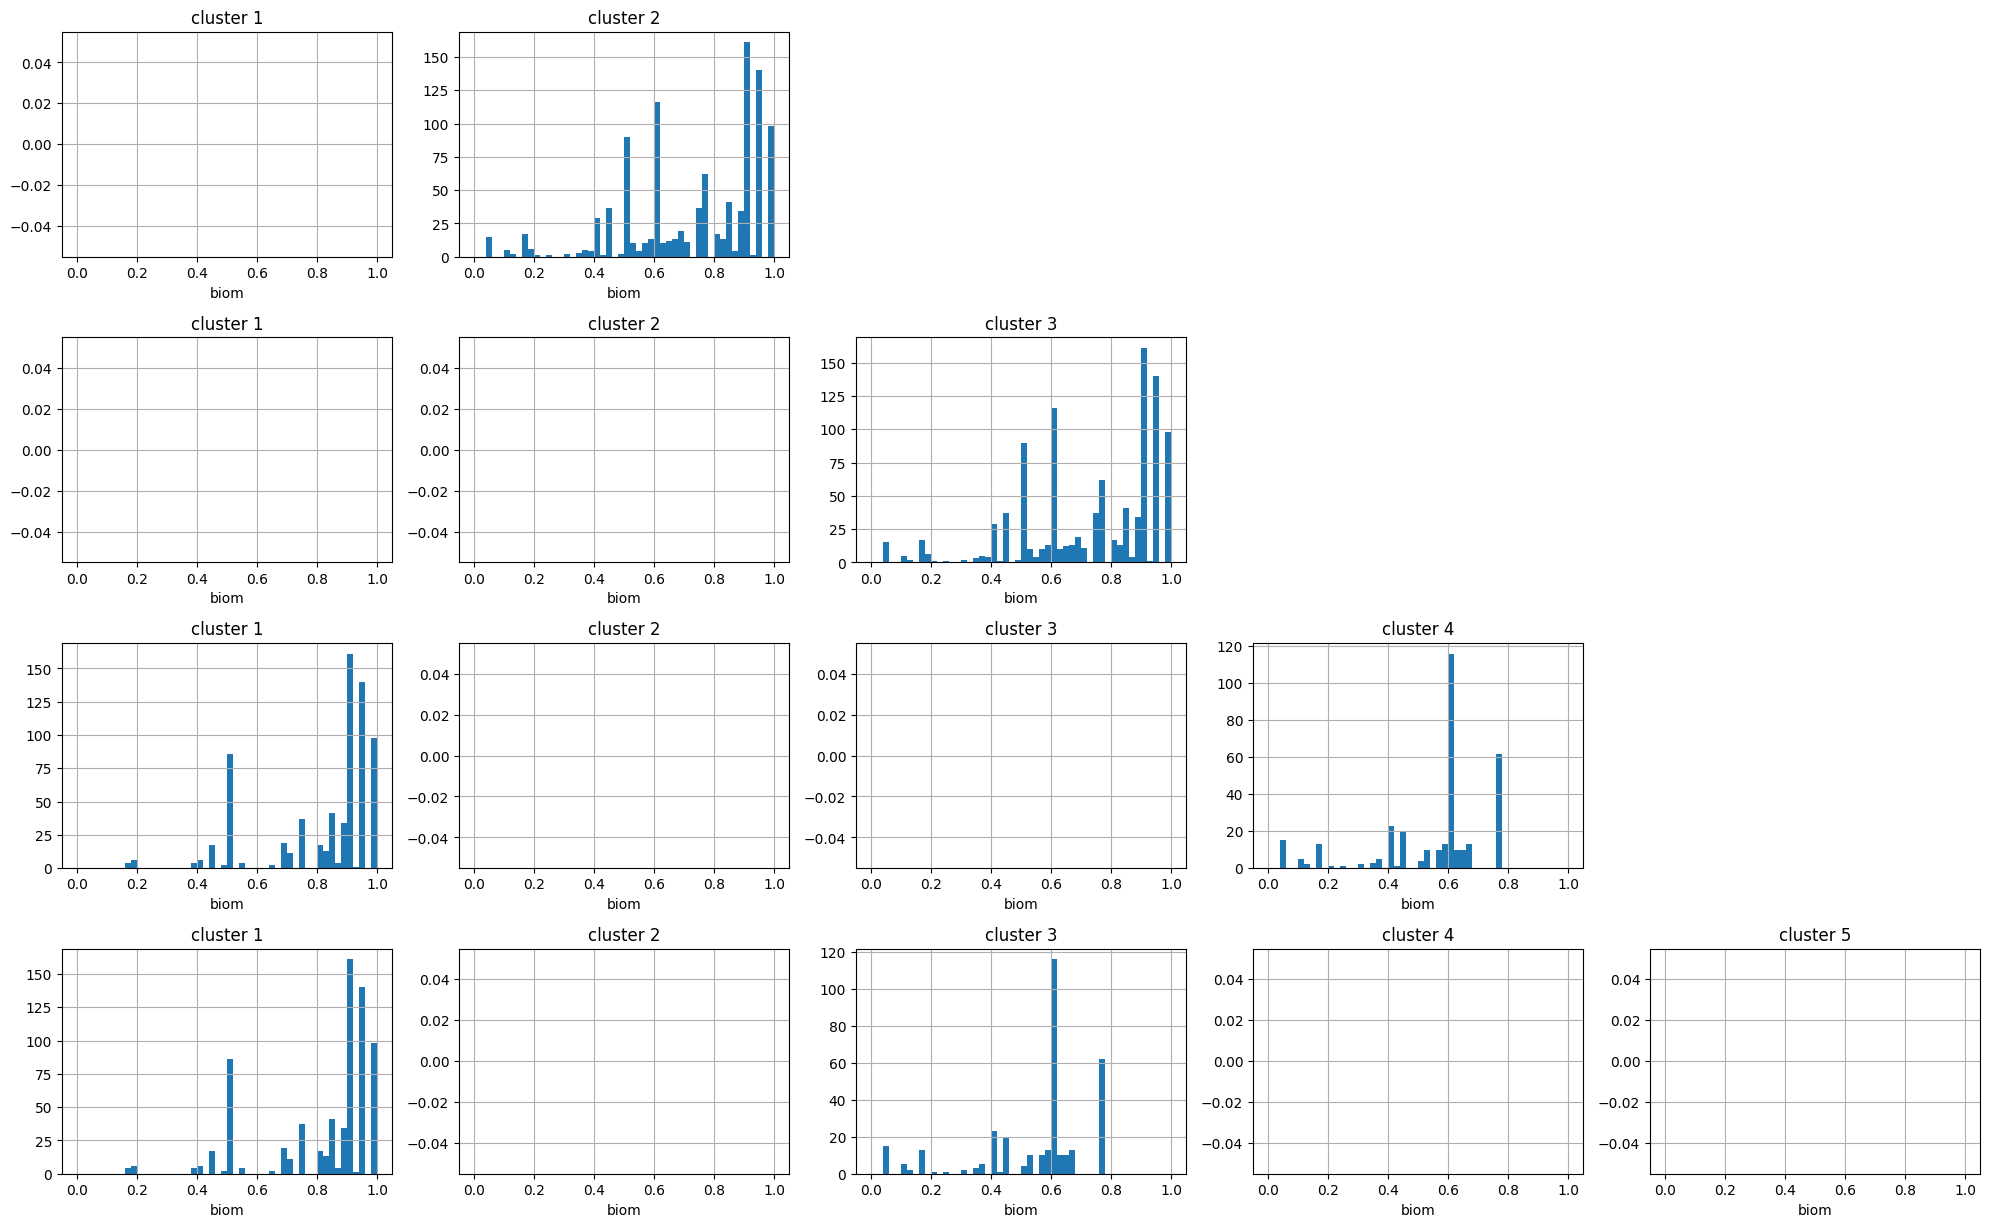

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Esegui K-means
KM_X = X7
k0, k1 = (2, 5)
plt.figure(figsize=(4*k1,3*k1))

fc = 0
# each row
for ki in range(k0, k1+1):
    
    kmeans = KMeans(n_clusters=ki)
    kmeans.fit(KM_X)

    # each col
    for kl in range(1, k1+1):
        fc+=1
        if kl > ki: continue
        plt.subplot(k1, k1, fc)
        sel = X3['fba.biom'][kmeans.labels_ == kl - 1]
        sel.hist(range=(0,1), bins=50)
        plt.title(f"cluster {kl}")
        plt.xlabel("biom")
plt.tight_layout()
plt.show()

___
### Experimental data

In [3]:
PROC_DIR = "/Users/Pereiro/.julia/dev/MetXCultureHub/data/raw/baldazziResourceAllocationAccounts2023/proc"

CSV_PATH = os.path.join(PROC_DIR, "Batch-elife-79815-supp1-v2.tsv")
GLC_BATCH_E0 = pd.read_csv(CSV_PATH,sep=',')
GLC_BATCH_E1 = GLC_BATCH_E0[GLC_BATCH_E0["Rate unit"] == 'mmol/gDW/h']

CSV_PATH = os.path.join(PROC_DIR, "Chemostat-elife-79815-supp1-v2.tsv")
GLC_CHTAT_E0 = pd.read_csv(CSV_PATH,sep=',')
GLC_CHTAT_E1 = GLC_CHTAT_E0[GLC_CHTAT_E0["Rate unit"] == 'mmol/gDW/h']

CSV_PATH = os.path.join(PROC_DIR, "Batch-elife-79815-supp2-v2.tsv")
GLYC_CHTAT_E0 = pd.read_csv(CSV_PATH,sep=',')
GLYC_CHTAT_E1 = GLYC_CHTAT_E0[GLYC_CHTAT_E0["Rate unit"] == 'mmol/gDW/h']

In [13]:
# TODO: make the plot theoric_max_X vs exp_X for all data...
# TODO: make ensemble with overflow limit 
# TODO: Make the ensembles with the dual co-culture model.
# TODO: try with the whole network
# TODO: Move this to julia + python

# Evolution dynamic hyphothesis:
# The interpretation of the MC is that it discover the hight density areas in the regulation effect phase space. If there are two point with equal fitness, the evolution should select the one with more desity because it is more likely. Assuming the such probability is proportional to the density of the space.

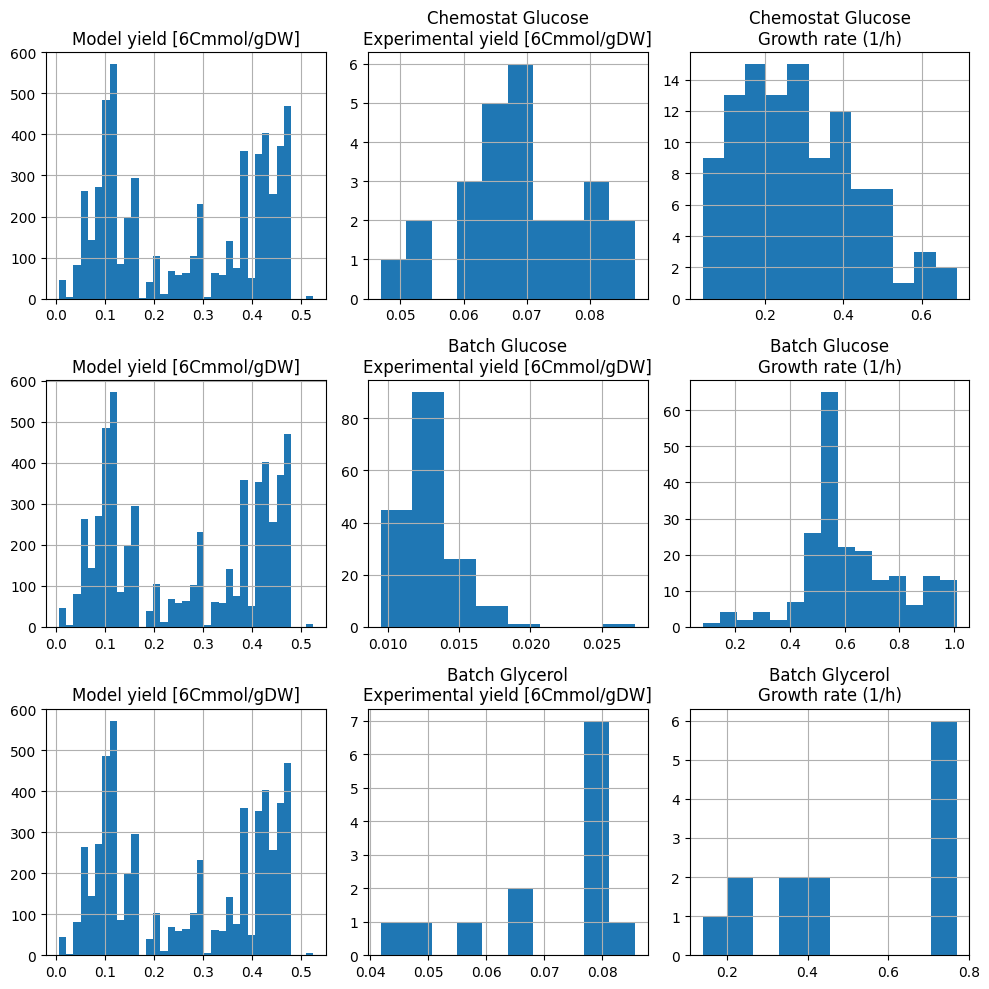

In [29]:
# Plot histograms

plt.figure(figsize=(10, 10))


# Chemostat Glucose
dattile = 'Chemostat Glucose'
plt.subplot(3, 3, 1)
X2['norm.fba.biom'].hist(bins=35)
plt.title('Model yield [6Cmmol/gDW]')
# plt.xlim([0, 0.1])

plt.subplot(3, 3, 2)
E1_Y = GLC_CHTAT_E1['Growth rate (1/h)'] / GLC_CHTAT_E1['Glucose uptake rate']
E1_Y.hist(bins=10)
plt.title(f'{dattile}\nExperimental yield [6Cmmol/gDW]')
# plt.xlim([0, 0.1])

plt.subplot(3, 3, 3)
GLC_CHTAT_E1['Growth rate (1/h)'].hist(bins=12)
plt.title(f'{dattile}\nGrowth rate (1/h)')
# plt.xlim([0, 1.0])

# Batch Glucose
dattile = 'Batch Glucose'
plt.subplot(3, 3, 4)
X2['norm.fba.biom'].hist(bins=35)
plt.title('Model yield [6Cmmol/gDW]')
# plt.xlim([0, 0.1])

plt.subplot(3, 3, 5)
E1_Y = GLC_BATCH_E1['Growth rate (1/h)'] / GLC_BATCH_E1['Glucose uptake rate'] / 6
E1_Y.hist(bins=8)
plt.title(f'{dattile}\nExperimental yield [6Cmmol/gDW]')
# plt.xlim([0, 0.1])

plt.subplot(3, 3, 6)
GLC_BATCH_E1['Growth rate (1/h)'].hist(bins=15)
plt.title(f'{dattile}\nGrowth rate (1/h)')
# plt.xlim([0, 1.0])

# Batch Glycerol
dattile = 'Batch Glycerol'
plt.subplot(3, 3, 7)
X2['norm.fba.biom'].hist(bins=35)
plt.title('Model yield [6Cmmol/gDW]')
# plt.xlim([0, 0.1])

plt.subplot(3, 3, 8)
E1_Y = GLYC_CHTAT_E1['Growth rate (1/h)'] / (GLYC_CHTAT_E1['Glycerol uptake rate'] / 2)
E1_Y.hist(bins=10)
plt.title(f'{dattile}\nExperimental yield [6Cmmol/gDW]')
# plt.xlim([0, 0.1])

plt.subplot(3, 3, 9)
GLYC_CHTAT_E1['Growth rate (1/h)'].hist(bins=10)
plt.title(f'{dattile}\nGrowth rate (1/h)')
# plt.xlim([0, 1.0])

# Mostra il grafico
plt.tight_layout()
plt.show()